In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")

from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

from sklearn import decomposition
from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, SpectralClustering, DBSCAN

In [2]:
spines = pd.read_csv('column_3C_weka.csv')
spines.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027818,22.552586,39.609117,40.475232,98.672917,-0.254400,Hernia
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Hernia
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,Hernia
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,Hernia
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,Hernia


## Scatter-Plot для базовой классификации

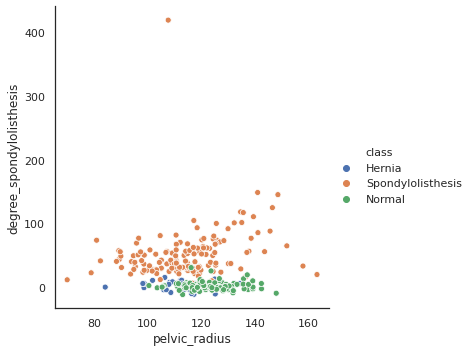

In [3]:
sns.relplot(x = 'pelvic_radius', y = 'degree_spondylolisthesis', hue = 'class', data = spines)

In [4]:
X = spines[['pelvic_radius', 'degree_spondylolisthesis']]
y = spines['class']

## Далее построим сразу k-means кластеризацию (для того, чтобы понять, зачем нам удалять 1 выброс)

In [5]:
km = KMeans(n_clusters=3)
y_km = km.fit_predict(X)

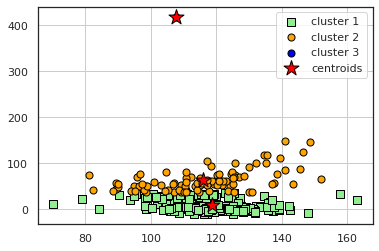

In [6]:
plt.scatter(
    X.iloc[y_km == 0, 0], X.iloc[y_km == 0, 1],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 1'
)

plt.scatter(
    X.iloc[y_km == 1, 0], X.iloc[y_km == 1, 1],
    s=50, c='orange',
    marker='o', edgecolor='black',
    label='cluster 2'
)

plt.scatter(
    X.iloc[y_km == 2, 0], X.iloc[y_km == 2, 1],
    s=50, c='blue',
    marker='o', edgecolor='black',
    label='cluster 3'
)

# plot the centroids
plt.scatter(
    km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

In [7]:
X[y_km == 2]

,pelvic_radius,degree_spondylolisthesis
115,107.690466,418.543082


Как видим из визуализации кластеров, есть выброс, который образует свой собственный кластер. Таким образом, мы можем относительно безболезненно от него избавиться.

In [8]:
X = X.drop(115, axis=0)
y = y.drop(115, axis=0)

## Расчет оптимального количества кластеров

In [9]:
# Анализ силуэтов для kmeans-кластеризации: чем ближе к +1, тем лучше

scores = []
for i in range(2, 11):
    i = int(i)
    kmeans = KMeans(n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0).fit_predict(X)
    score = metrics.silhouette_score(X, kmeans)
    scores.append(score)

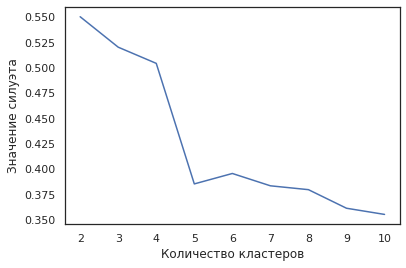

In [10]:
plt.plot(range(2, 11), scores)
plt.xlabel('Количество кластеров')
plt.ylabel('Значение силуэта')
plt.show()

Как видно по графику, наиболее приемлимые значения количества кластеров от 2 до 4. Притом, наилучшее значение для кластериизации k = 2. 

## k-means кластеризация

In [11]:
km = KMeans(n_clusters=2, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0)
y_km = km.fit_predict(X)

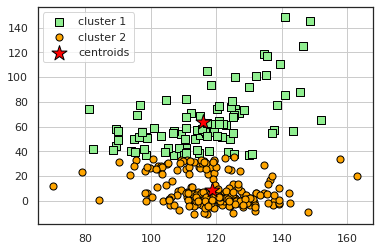

In [12]:
plt.scatter(
    X.iloc[y_km == 0, 0], X.iloc[y_km == 0, 1],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 1'
)

plt.scatter(
    X.iloc[y_km == 1, 0], X.iloc[y_km == 1, 1],
    s=50, c='orange',
    marker='o', edgecolor='black',
    label='cluster 2'
)

# plot the centroids
plt.scatter(
    km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

## Иерархическая кластеризация

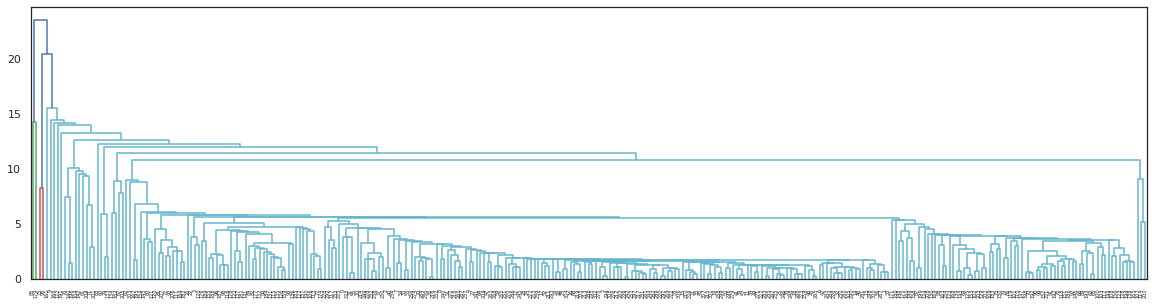

In [13]:
distance_mat = pdist(X)
Z = hierarchy.linkage(distance_mat, 'single') 
plt.figure(figsize=(20, 5))
dn = hierarchy.dendrogram(Z)

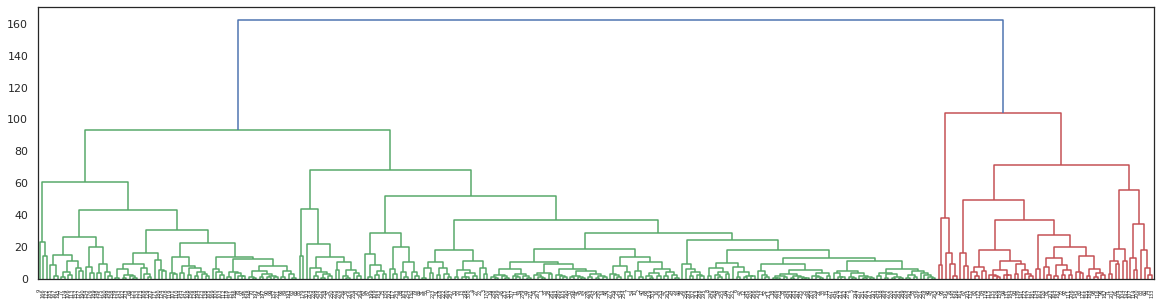

In [14]:
Z = hierarchy.linkage(distance_mat, 'complete') 
plt.figure(figsize=(20, 5))
dn = hierarchy.dendrogram(Z)

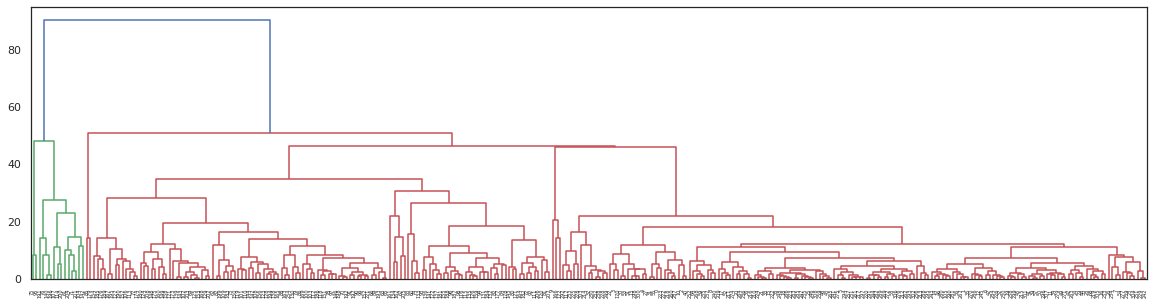

In [15]:
Z = hierarchy.linkage(distance_mat, 'average') 
plt.figure(figsize=(20, 5))
dn = hierarchy.dendrogram(Z)

Наиболее равномерная кластеризация наблюдается при значении параметра иерархической кластеризации linkage = complite. 

In [16]:
import warnings
warnings.filterwarnings('ignore')

In [17]:
algorithms = []
algorithms.append(KMeans(n_clusters=2))
algorithms.append(AgglomerativeClustering(n_clusters=2, linkage='single'))
algorithms.append(AgglomerativeClustering(n_clusters=2, linkage='complete'))
algorithms.append(AgglomerativeClustering(n_clusters=2, linkage='average'))


data = []
for algo in algorithms:
    algo.fit(X)
    data.append(({
        'ARI': metrics.adjusted_rand_score(y, algo.labels_),
        'AMI': metrics.adjusted_mutual_info_score(y, algo.labels_),
        'Homogenity': metrics.homogeneity_score(y, algo.labels_),
        'Completeness': metrics.completeness_score(y, algo.labels_),
        'V-measure': metrics.v_measure_score(y, algo.labels_),
        'Silhouette': metrics.silhouette_score(X, algo.labels_)}))

results = pd.DataFrame(data=data, columns=['ARI', 'AMI','Homogenity',
                                           'Completeness', 'V-measure', 
                                           'Silhouette'],
                       index=['K-means', 'Agglomerative-single', 
                              'Agglomerative-complete', 'Agglomerative-average'])

results

,ARI,AMI,Homogenity,Completeness,V-measure,Silhouette
K-means,0.184625,0.280291,0.282563,0.478143,0.355211,0.550135
Agglomerative-single,-0.004381,0.000811,0.004583,0.121401,0.008832,0.278556
Agglomerative-complete,0.017778,0.158844,0.161512,0.339636,0.218918,0.550549
Agglomerative-average,-0.025447,0.032246,0.035495,0.189180,0.059774,0.589202


Судя по метрикам, наилучшей кластеризацией в данном случае будет k-means (на втором месте Agglomerative-complete).  

## PCA

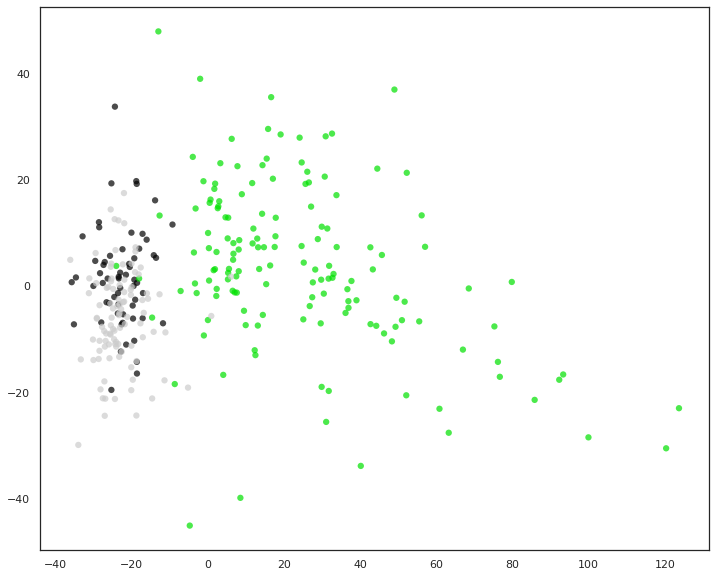

In [18]:
pca = decomposition.PCA(n_components=2)
X_reduced = pca.fit_transform(X)

plt.figure(figsize=(12,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=pd.factorize(y)[0], 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
# plt.colorbar()